In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
class Single:
    def __init__(self, data, _children=(), _operator='', label=""):
        self.data = data
        self._children = set(_children)
        self._operator = _operator
        self.label = label
        self.gradient = 0.0
        self._backpropagation = lambda: None
    def __repr__(self):
        return f"[data={self.data}]"
    def __add__(self, other):
        other = other if (isinstance(other, Single)) else Single(other)
        output = Single(self.data + other.data, (self, other), '+')

        def _backpropagation():
            self.gradient += 1.0 * output.gradient
            other.gradient += 1.0 * output.gradient
        output._backpropagation = _backpropagation
        
        return output
    def __radd__(self, other):
        return self + other
    def __mul__(self, other):
        other = other if (isinstance(other, Single)) else Single(other)
        output = Single(self.data * other.data, (self, other), '*')

        def _backpropagation():
            self.gradient += other.data * output.gradient
            other.gradient += self.data * output.gradient
        output._backpropagation = _backpropagation

        return output
    def __rmul__(self, other):
        return self * other
    def __neg__(self):
        return -1 * self
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return (-self) + other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Error, only (int & float are supported)"
        output = Single(self.data ** other, (self,), f'**{other}')

        def _backpropagation():
            self.gradient += other * (self.data ** (other - 1)) * output.gradient
        output._backpropagation = _backpropagation

        return output
    def __truediv__(self, other):
        return self * (other**-1)
    def __rtruediv__(self, other):
        return (self**-1) * other
    def sigmoid(self):
        x = self.data
        y = 1 / (1 + math.exp(-x))
        output = Single(y, (self,), 'sigmoid')

        def _backpropagation():
            self.gradient += math.exp(-x) / ((1 + math.exp(-x)) ** 2) * output.gradient
        output._backpropagation = _backpropagation
        
        return output
    def exp(self):
        x = self.data
        y = math.exp(x)
        output = Single(y, (self,), 'exp')

        def _backpropagation():
            self.gradient += y * output.gradient
        output._backpropagation = _backpropagation

        return output
    # 100% copied from Andrej Karpathy's video
    def backpropagation(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._children:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.gradient = 1.0
        for node in reversed(topo):
          node._backpropagation()

In [64]:
# 100% copied from Andrej Karpathy's video
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | gradient %.4f }" % (n.label, n.data, n.gradient), shape='record')
    if n._operator:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operator, label = n._operator)
      # and connect this node to it
      dot.edge(uid + n._operator, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operator)

  return dot

In [107]:
x = Single(1)
y = Single(2)
z = x+y
k = 2 * z
a = k ** 2.0
b = 1 / a
b.backpropagation()

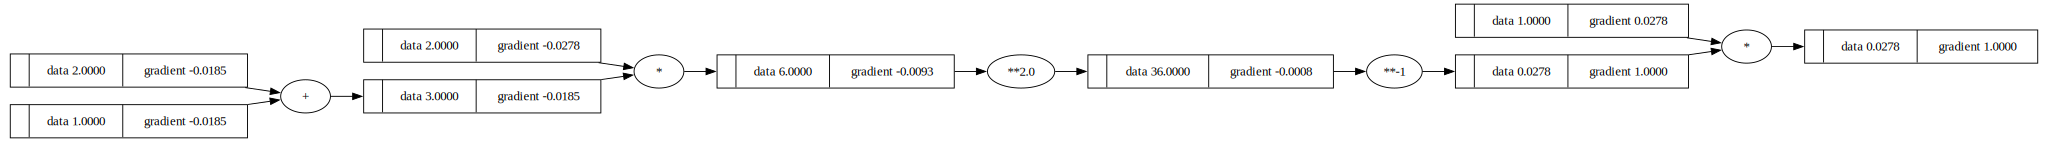

In [103]:
draw_dot(b)

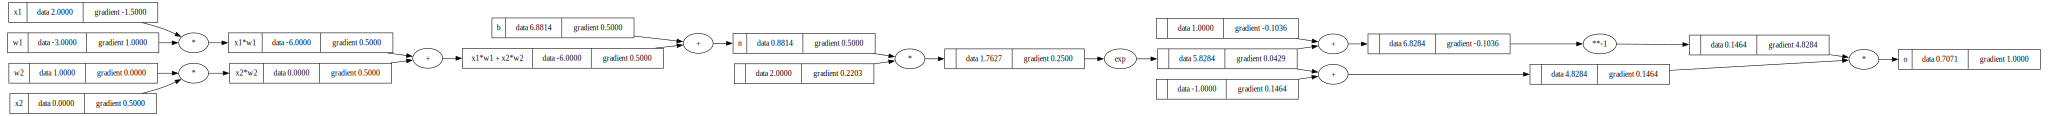

In [112]:
# inputs x1,x2
x1 = Single(2.0, label='x1')
x2 = Single(0.0, label='x2')
# weights w1,w2
w1 = Single(-3.0, label='w1')
w2 = Single(1.0, label='w2')
# bias of the neuron
b = Single(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backpropagation()
draw_dot(o)